# Google Notebook specific Stuff

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install pytorch-lightning==1.3.3
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
!pip install scGeneFit
!pip install scanpy
!pip install anndata
!pip install lassonet
# my version of smashpy that fixed imports, nothing else was changed
!pip install matplotlib>=3.3.2
!pip install shap>=0.37.0
!pip install xgboost>=1.3.3
!pip install imbalanced-learn>=0.7.0
!pip install numba>=0.51.2
!pip install harmonypy>=0.0.5
!pip install smashpy
!git clone https://github.com/ahsv/RankCorr.git

     |████████████████████████████████| 806 kB 14.3 MB/s 
     |████████████████████████████████| 829 kB 70.0 MB/s 
     |████████████████████████████████| 282 kB 71.1 MB/s 
     |████████████████████████████████| 125 kB 72.7 MB/s 
     |████████████████████████████████| 636 kB 72.2 MB/s 
     |████████████████████████████████| 1.3 MB 63.3 MB/s 
     |████████████████████████████████| 271 kB 88.5 MB/s 
     |████████████████████████████████| 160 kB 87.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=799a88f571188a2d1bae514a8551eb7baa06b8a0ecd1bfffc6c8017956b84676
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-

Cloning into 'RankCorr'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 2), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [2]:
# Check GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
import sys
import os
# to import utils
sys.path.append(os.path.abspath('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks'))

# All the Imports

In [4]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier



from RankCorr.picturedRocks import Rocks
import smashpy as smashpy

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


CPU times: user 3.44 s, sys: 510 ms, total: 3.95 s
Wall time: 3.96 s


# These should be parameters later on 

In [5]:
z_size = 16
hidden_layer_size = 64

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 25, 50, 100, 250]
num_times = 5
k = 50
gpus = 1
tpu_cores = None

In [6]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [7]:
from os import path

In [8]:
dataset_dir = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/CITE-seq/'
model_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/CITE-seq/models/'
viz_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/CITE-seq/visualizations/'

if not path.exists(model_save_path):
  os.mkdir(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.mkdir(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.mkdir(viz_save_path)

  

# Dataset Specific Processing

`

In [9]:
citeseq_adata = sc.read_h5ad(dataset_dir + "CITEseq.h5ad")

In [10]:
citeseq_adata.shape

(8617, 500)

In [11]:
X = citeseq_adata.X.copy()

In [12]:
np.apply_along_axis(np.mean, 0, X)

array([ 1.4166219e-08,  0.0000000e+00, -1.8371816e-08, -1.7707775e-08,
        0.0000000e+00,  0.0000000e+00, -1.0624665e-08,  7.0831097e-09,
       -1.0624665e-08,  3.5415548e-09, -7.3044570e-09, -7.0831097e-09,
        1.4166219e-08,  0.0000000e+00,  3.5415548e-09,  0.0000000e+00,
        2.1249329e-08, -7.0831097e-09,  7.0831097e-09,  1.7707774e-09,
        3.5415548e-09, -7.0831097e-09, -7.0831097e-09, -1.0624665e-08,
        7.0831097e-09,  2.6561662e-09, -7.0831097e-09, -7.0831097e-09,
        0.0000000e+00,  6.6404154e-10,  0.0000000e+00,  0.0000000e+00,
       -7.0831097e-09,  1.0624665e-08,  7.0831097e-09, -5.3123324e-09,
       -3.5415548e-09, -3.5415548e-09, -1.4166219e-08,  1.7707774e-09,
       -3.5415548e-09, -1.0624665e-08, -1.0624665e-08,  1.4166219e-08,
        1.0624665e-08,  1.7707775e-08, -2.1249329e-08,  4.8696380e-09,
        8.8538874e-09, -1.0624665e-08,  1.0624665e-08, -3.5415548e-09,
        3.5415548e-09, -4.4269435e-10,  0.0000000e+00,  1.0624665e-08,
      

In [13]:
np.apply_along_axis(np.var, 0, X)

array([0.99988383, 0.99988395, 0.99988395, 0.99988395, 0.99988395,
       0.99988395, 0.99988395, 0.99988395, 0.99988395, 0.99988395,
       0.99988395, 0.99988407, 0.99988395, 0.99988395, 0.99988395,
       0.99988395, 0.99988395, 0.99988395, 0.99988395, 0.99988407,
       0.99988395, 0.99988407, 0.99988395, 0.99988395, 0.99988395,
       0.99988395, 0.99988395, 0.99988395, 0.99988395, 0.99988395,
       0.99988395, 0.99988395, 0.99988395, 0.99988395, 0.99988383,
       0.99988395, 0.99988395, 0.99988407, 0.99988395, 0.99988395,
       0.99988395, 0.99988395, 0.99988395, 0.99988407, 0.99988395,
       0.99988383, 0.99988395, 0.99988395, 0.99988395, 0.99988395,
       0.99988395, 0.99988395, 0.99988395, 0.99988407, 0.99988407,
       0.99988395, 0.99988395, 0.99988395, 0.99988395, 0.99988395,
       0.99988395, 0.99988395, 0.99988395, 0.99988395, 0.99988395,
       0.99988395, 0.99988395, 0.99988395, 0.99988395, 0.99988407,
       0.99988395, 0.99988395, 0.99988395, 0.99988395, 0.99988

In [14]:
citeseq_adata.obs['annotation'] = citeseq_adata.obs['names']
labels = citeseq_adata.obs['names'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [15]:
input_size = X.shape[1]

In [16]:
X.shape

(8617, 500)

# Set Up Models

## All Markers

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

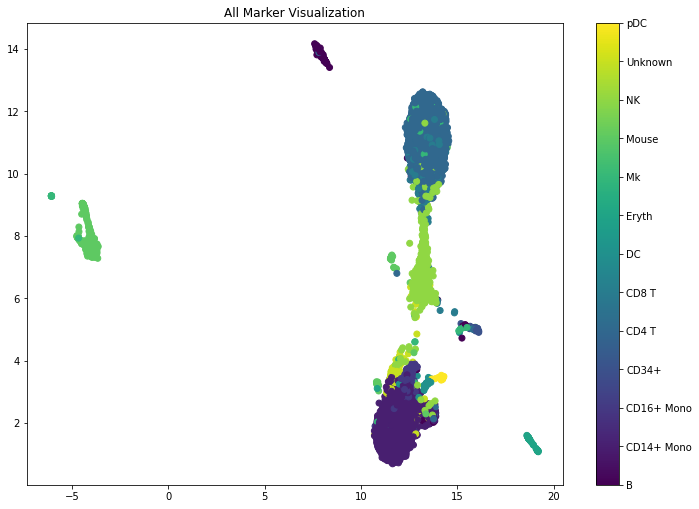

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



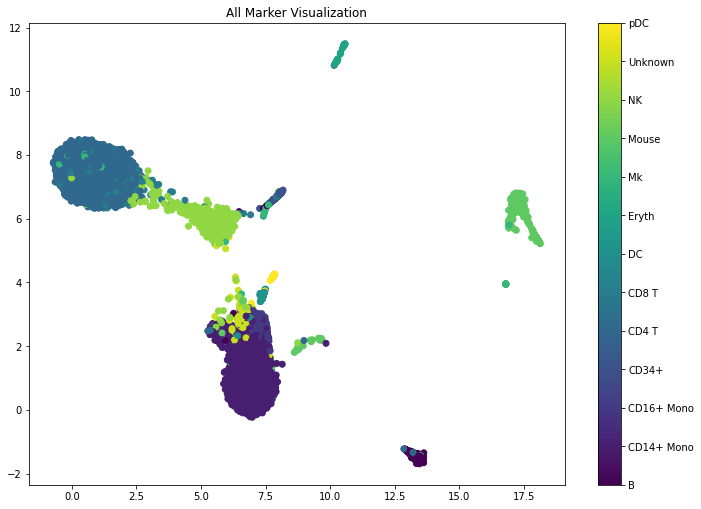

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



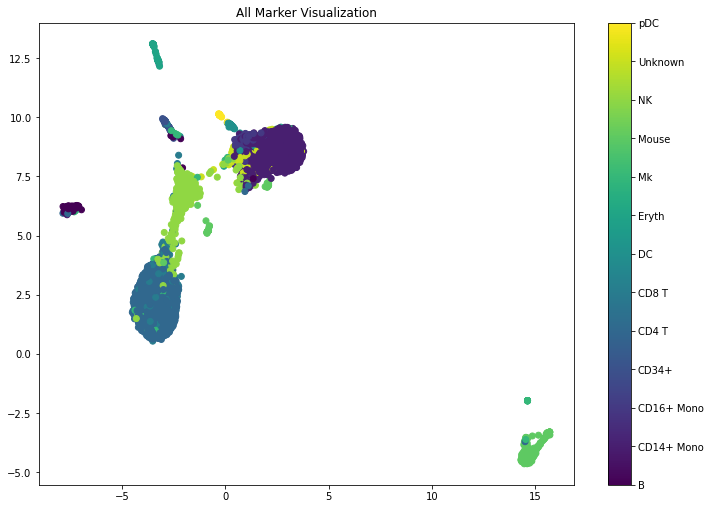

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



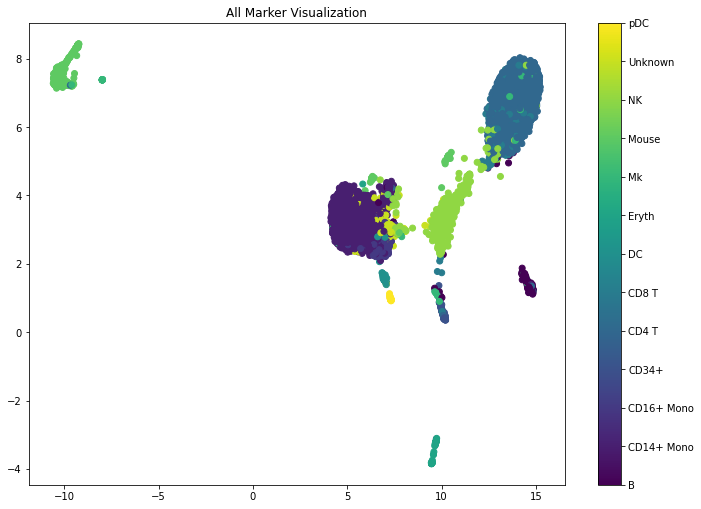

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



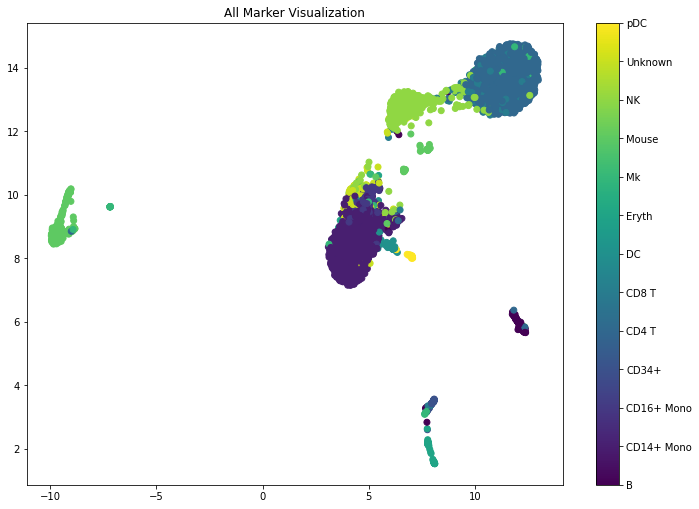

CPU times: user 4min 50s, sys: 2.42 s, total: 4min 53s
Wall time: 3min 27s


In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)

## Train Smash Random Forest





In [ ]:
# needed for random forest Smash
!mkdir Figures

In [ ]:
%%time
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_k_{}.png'.format(k), markers = smash_markers)

In [ ]:
results

## Train Smash DNN

the data is treated a bit differently than our other models

In [ ]:
%%time
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(citeseq_adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(citeseq_adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_k_{}.png'.format(k), markers = smash_markers)

In [ ]:
results

## Train RankCorr

In [ ]:
lamb_range = [0.5, 1.5, 3, 7, 21.9]
lamb_i = 0

In [ ]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = lamb_range[lamb_i]
    lamb_i = lamb_i + 1

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        print(lamb)
        print(len(rankcorr_markers))
        print(k)
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        print("Excess Length of markers")
        print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(citeseq_adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_k_{}.png'.format(k), markers = rankcorr_markers)

In [ ]:
len(rankcorr_markers)

In [ ]:
print("Some, if not all, selected gene names")
print(marker_genes)

In [ ]:
results

## Train L1 VAE

In [ ]:
feature_std = torch.tensor(X).std(dim = 0)
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = 16)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'l1_vae_markers_k_{}.npy'.format(k), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_k_{}.png'.format(k), markers = l1_markers)

In [ ]:
results

## Train Global Gate

In [ ]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_k_{}.png'.format(k), markers = globalgate_markers)

In [ ]:
model.t

In [ ]:
results

## Train Running State VAE

In [ ]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = VAE_Gumbel_RunningState(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'runningstate_vae_markers_k_{}.npy'.format(k), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE Marker Visualization', path = viz_save_path + 'runningstate_vae_markers_k_{}.png'.format(k), markers = runningstate_markers)

In [ ]:
model.t

In [ ]:
results

In [ ]:
model.t

## Running State Classifier

In [ ]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = GumbelClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_classifier_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_classifier_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'runningstate_classifier_markers_k_{}.npy'.format(k), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_classifier_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State Classifier Marker Visualization', path = viz_save_path + 'runningstate_classifier_markers_k_{}.png'.format(k), markers = runningstate_markers)

In [ ]:
model.lr

In [ ]:
model.t

In [ ]:
model.hparams.lr

In [ ]:
results

## RunningState VAE+Classifier

In [ ]:
for tryy in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = RunningState_VAE_Classifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = tryy, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae+classifier_k_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'runningstate_vae+classifier_results_k_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae+classifier_markers_k_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae+classifier_indices_k_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE+Classifier Marker Visualization', path = viz_save_path + 'runningstate_vae+classifier_markers_k_{}.png'.format(tryy), markers = markers)

In [ ]:
results

## Concrete VAE

In [ ]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_k_{}.ckpt'.format(k)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_k_{}.png'.format(k), markers = concrete_vae_markers)

In [ ]:
results = np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)

In [ ]:
results

## LassoNet

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from functools import partial
from lassonet import plot_path

In [ ]:
k = 50
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

In [ ]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))
    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_k_{}.png'.format(k), markers = lasso_net_markers)

In [ ]:
results

## Get Model Metrics from KNNs Classifiers


In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

In [44]:
def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae_indices_{}.npy',
                                  model_save_path+'runningstate_vae_markers_{}.npy',
                                  model_save_path+'runningstate_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_classifier_indices_{}.npy',
                                  model_save_path+'runningstate_classifier_markers_{}.npy',
                                  model_save_path+'runningstate_classifier_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_markers_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

### Generate the same metrics using the various K ranges instead

In [45]:
# for looking at things that did one trial
def batch_generate_metrics_from_saved_files_limited(X, y, format_folds_path, format_markers_path, format_save_path):
    for k in k_range:
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(k), format_markers_path.format(k), classifier_model, format_save_path.format(k))
    return

In [47]:
batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_k_{}.npy',
                                  model_save_path+'l1_vae_markers_k_{}.npy',
                                  model_save_path+'l1_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_k_{}.npy',
                                  model_save_path+'smash_rf_markers_k_{}.npy',
                                  model_save_path+'smash_rf_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_k_{}.npy',
                                  model_save_path+'smash_markers_k_{}.npy',
                                  model_save_path+'smash_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_k_{}.npy',
                                  model_save_path+'rankcorr_markers_k_{}.npy',
                                  model_save_path+'rankcorr_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_k_{}.npy',
                                  model_save_path+'globalgate_vae_markers_k_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae_indices_k_{}.npy',
                                  model_save_path+'runningstate_vae_markers_k_{}.npy',
                                  model_save_path+'runningstate_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_classifier_indices_k_{}.npy',
                                  model_save_path+'runningstate_classifier_markers_k_{}.npy',
                                  model_save_path+'runningstate_classifier_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae+classifier_indices_k_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_markers_k_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_k_{}.npy',
                                  model_save_path+'concrete_vae_markers_k_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_k_{}.npy',
                                  model_save_path+'lasso_net_markers_k_{}.npy',
                                  model_save_path+'lasso_net_knn_results_k_{}.npy')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

# Results and Visualizations

In [ ]:
k = 50

## Accuracies and F1

In [ ]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('RunningGumbel VAE', 'runningstate_vae_results_{}.npy', 'runningstate_vae_knn_results_{}.npy'),
 ('RunningGumbel Classifier', 'runningstate_classifier_results_{}.npy', 'runningstate_classifier_knn_results_{}.npy'),
 ('RunningGumbel VAE+Classifier', 'runningstate_vae+classifier_results_{}.npy', 'runningstate_vae+classifier_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

,Misclassification Mean,Weighted F1 Mean,Misclassification Standard Deviation,Weighted F1 Standard Deviation
All Markers,0.072042,0.906990,0.005434,0.007775
L1 VAE,0.122854,0.844842,0.016404,0.020716
Smash RF,0.068561,0.915151,0.002088,0.003580
SMaSH DNN,0.067053,0.917462,0.003606,0.005150
RankCorr,0.068677,0.911849,0.004045,0.005910
Global Gate VAE,0.125986,0.837386,0.023414,0.031153
RunningGumbel VAE,0.092923,0.881889,0.009240,0.012684
RunningGumbel Classifier,0.062877,0.923783,0.004062,0.005541
RunningGumbel VAE+Classifier,0.064501,0.921332,0.003164,0.004876
Concrete VAE,0.124478,0.838116,0.023125,0.031114


In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

,Misclassification Mean,Weighted F1 Mean,Misclassification Standard Deviation,Weighted F1 Standard Deviation
All Markers,0.093387,0.903923,0.003342,0.002542
L1 VAE,0.178190,0.797884,0.021568,0.024682
Smash RF,0.072506,0.914602,0.002320,0.004322
SMaSH DNN,0.066705,0.920939,0.003576,0.005118
RankCorr,0.080858,0.905313,0.003104,0.005212
Global Gate VAE,0.200348,0.770226,0.028639,0.032964
RunningGumbel VAE,0.115545,0.873742,0.017345,0.018876
RunningGumbel Classifier,0.062065,0.928886,0.006764,0.008644
RunningGumbel VAE+Classifier,0.068910,0.920865,0.002332,0.003085
Concrete VAE,0.182483,0.788696,0.024545,0.028788


## Confusion Matrices

k = 50

### All Markers

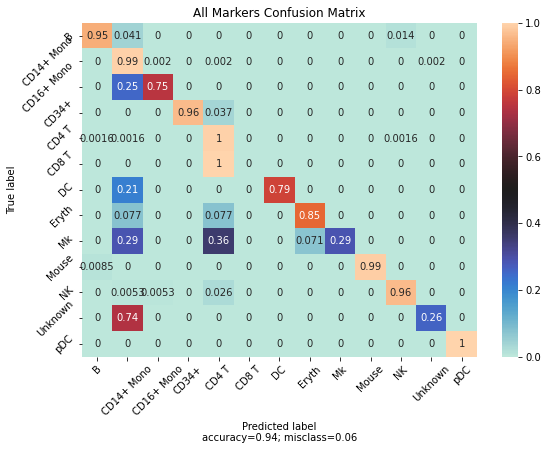

In [ ]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [ ]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

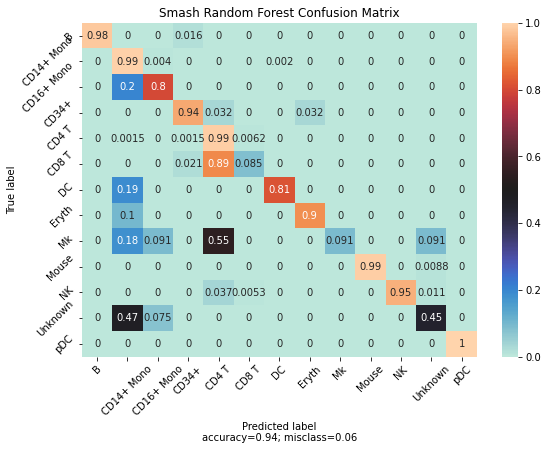

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

In [ ]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)

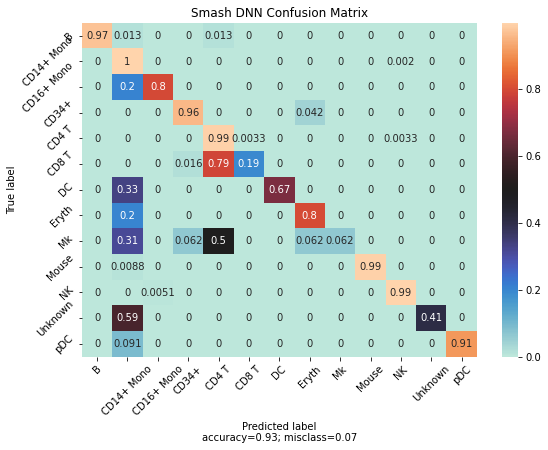

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

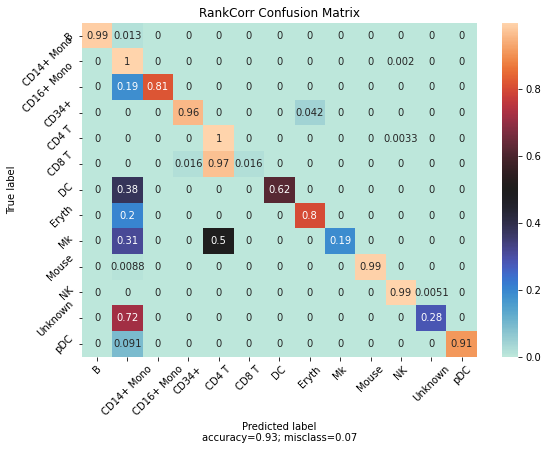

In [ ]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

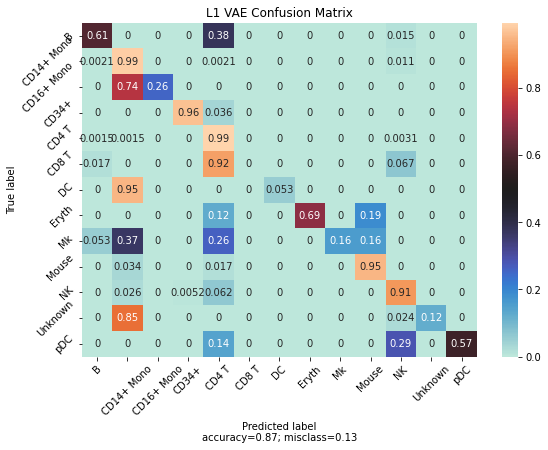

In [ ]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

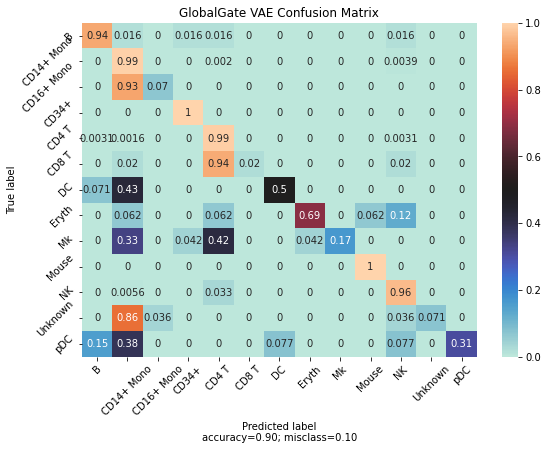

In [ ]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### Running Gumbel VAE

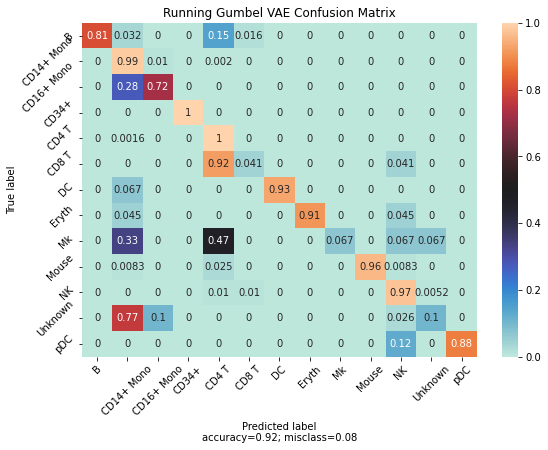

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE Confusion Matrix', save_path = viz_save_path + 'runningstate_vae_cm.pdf', cmap = 'icefire')

### Running Gumbel Classifier


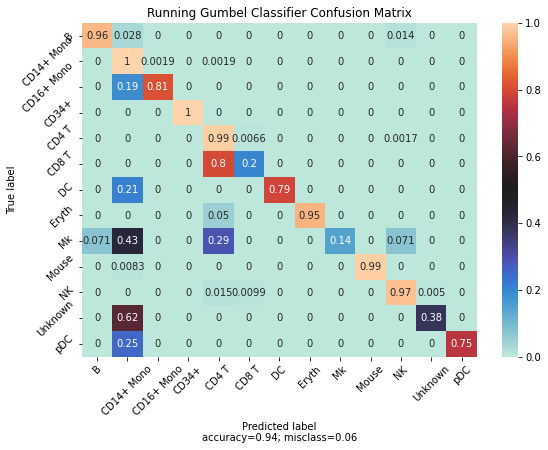

In [ ]:
results =  np.load(model_save_path + 'runningstate_classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_classifier_cm.pdf', cmap = 'icefire')

### RunningState VAE+Classifier

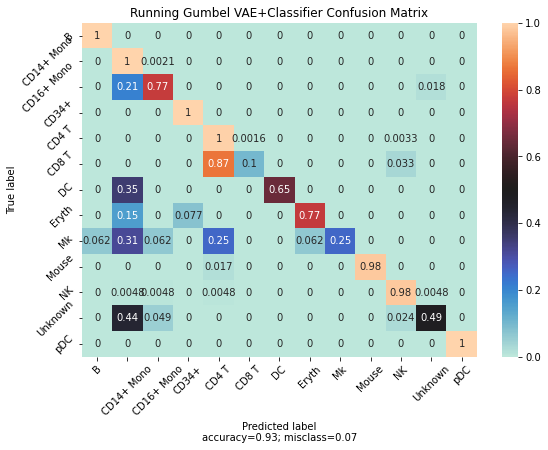

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE+Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_vae+classifier_cm.pdf', cmap = 'icefire')

### Concrete VAE

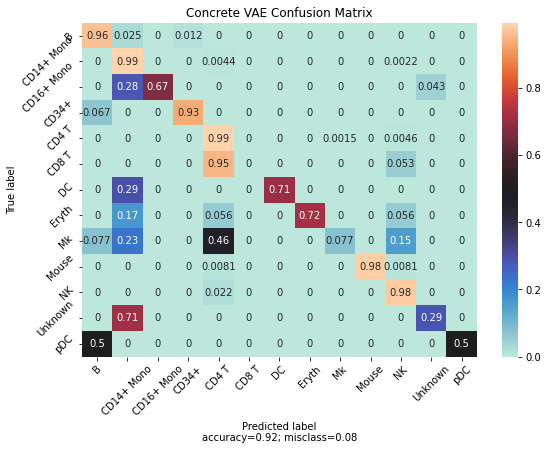

In [ ]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

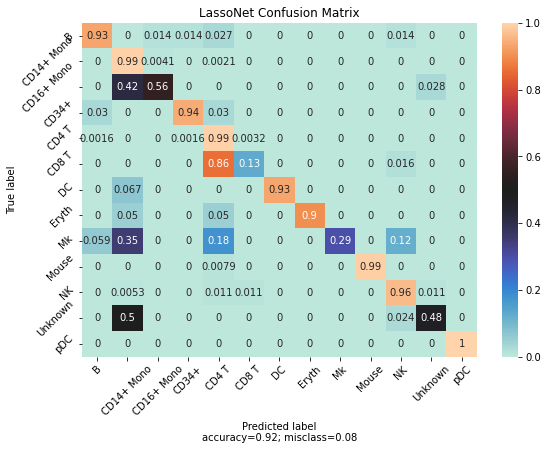

In [ ]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')

## UMap Visualization

In [ ]:
import cv2

In [ ]:
img = cv2.imread(viz_save_path + 'smash_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'rankcorr_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae+classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'concrete_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'lasso_net_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

## Visualizing Reconstructions

from first model of each

## L1 VAE

In [ ]:
model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_{}.ckpt'.format(1))
l1_vae_markers = np.load(model_save_path + 'l1_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'L1 VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_l1_vae_{}.png'.format(1), markers = l1_vae_markers)

### Global Gate VAE

In [ ]:
model = load_model(VAE_Gumbel_GlobalGate, model_save_path + 'globalgate_vae_{}.ckpt'.format(1))
globalgate_vae_markers = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Global Gate VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_globalgate_vae_{}.png'.format(1), markers = globalgate_vae_markers)

### Running State Gumbel VAE

In [ ]:
model = load_model(VAE_Gumbel_RunningState, model_save_path + 'runningstate_vae_{}.ckpt'.format(1))


In [ ]:
runningstate_vae_markers = np.load(model_save_path + 'runningstate_vae_markers_{}.npy'.format(1), allow_pickle=True)

In [ ]:
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]

In [ ]:
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_runningstate_vae_{}.png'.format(1), markers = runningstate_vae_markers)

### RunningState VAE+Classifier

In [ ]:
model = load_model(RunningState_VAE_Classifier, model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(1))
runningstate_vae_classifier_markers = np.load(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE+Classifier Reconstruction Marker Visualization', 
                         path = viz_save_path + 'recon_runningstate_vae+classifier_{}.png'.format(1), markers = runningstate_vae_classifier_markers)

Concrete VAE

In [ ]:
model = load_model(ConcreteVAE_NMSL, model_save_path + 'concrete_vae_{}.ckpt'.format(1))
concrete_vae_markers = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Concrete VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_concrete_vae_{}.png'.format(1), markers = concrete_vae_markers)

## Visualizing k on weighted f1

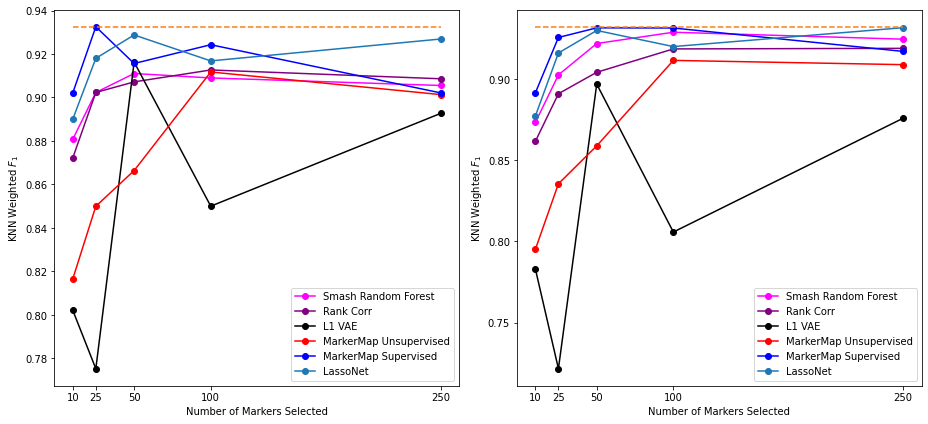

In [102]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

runningstate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_scores.append(rep['weighted avg']['f1-score'])

runningstate_classifier_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_classifier_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_classifier_scores.append(rep['weighted avg']['f1-score'])


runningstate_vae_classifier_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_vae+classifier_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_classifier_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, runningstate_vae_scores, runningstate_classifier_scores, 
          runningstate_vae_classifier_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, runningstate_vae_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, runningstate_classifier_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, runningstate_vae_classifier_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

runningstate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_scores.append(rep['weighted avg']['f1-score'])

runningstate_classifier_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_classifier_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_classifier_scores.append(rep['weighted avg']['f1-score'])


runningstate_vae_classifier_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_vae+classifier_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_classifier_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, runningstate_vae_scores, runningstate_classifier_scores, 
          runningstate_vae_classifier_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, runningstate_vae_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, runningstate_classifier_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, runningstate_vae_classifier_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k.pdf')

#### Include everything

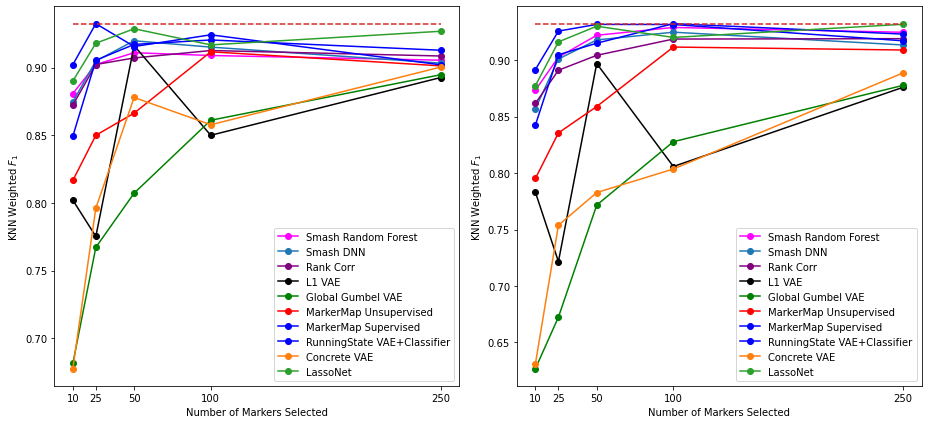

In [104]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

runningstate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_scores.append(rep['weighted avg']['f1-score'])

runningstate_classifier_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_classifier_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_classifier_scores.append(rep['weighted avg']['f1-score'])


runningstate_vae_classifier_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_vae+classifier_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_classifier_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, runningstate_vae_scores, runningstate_classifier_scores, 
          runningstate_vae_classifier_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, runningstate_vae_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, runningstate_classifier_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, runningstate_vae_classifier_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

runningstate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_scores.append(rep['weighted avg']['f1-score'])

runningstate_classifier_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_classifier_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_classifier_scores.append(rep['weighted avg']['f1-score'])


runningstate_vae_classifier_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'runningstate_vae+classifier_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_classifier_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, runningstate_vae_scores, runningstate_classifier_scores, 
          runningstate_vae_classifier_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, runningstate_vae_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, runningstate_classifier_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, runningstate_vae_classifier_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k_all.pdf')

### Do Misclassification now

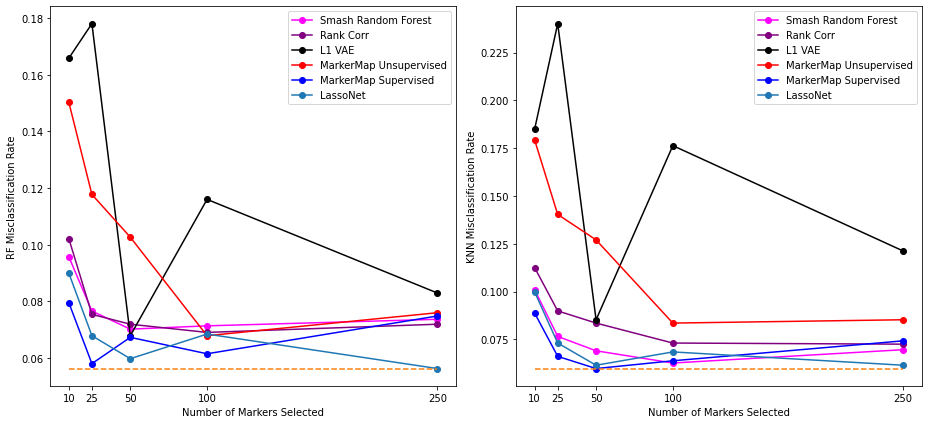

In [105]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

runningstate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_scores.append(m)

runningstate_classifier_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_classifier_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_classifier_scores.append(m)

runningstate_vae_classifier_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_vae+classifier_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_classifier_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, runningstate_vae_scores, runningstate_classifier_scores, 
          runningstate_vae_classifier_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, runningstate_vae_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, runningstate_classifier_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, runningstate_vae_classifier_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

runningstate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_scores.append(m)

runningstate_classifier_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_classifier_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_classifier_scores.append(m)

runningstate_vae_classifier_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_vae+classifier_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_classifier_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, runningstate_vae_scores, runningstate_classifier_scores, 
          runningstate_vae_classifier_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, runningstate_vae_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, runningstate_classifier_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, runningstate_vae_classifier_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k.pdf')

##### Include everything

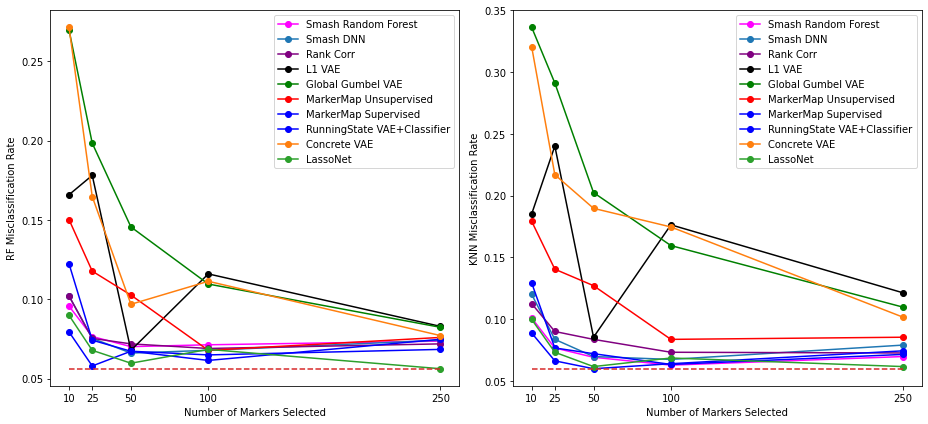

In [106]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

runningstate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_scores.append(m)

runningstate_classifier_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_classifier_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_classifier_scores.append(m)

runningstate_vae_classifier_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_vae+classifier_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_classifier_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, runningstate_vae_scores, runningstate_classifier_scores, 
          runningstate_vae_classifier_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, runningstate_vae_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, runningstate_classifier_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, runningstate_vae_classifier_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

runningstate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_scores.append(m)

runningstate_classifier_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_classifier_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_classifier_scores.append(m)

runningstate_vae_classifier_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'runningstate_vae+classifier_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    runningstate_vae_classifier_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, runningstate_vae_scores, runningstate_classifier_scores, 
          runningstate_vae_classifier_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, runningstate_vae_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, runningstate_classifier_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, runningstate_vae_classifier_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k_all.pdf')

## Visualize Marker Selection

### Smash RF

In [ ]:
smash_rf_markers = {}
smash_rf_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_rf_markers[k] = marker_data
    smash_rf_f1[k] = weighted_f1_score

### Smash DNN

In [ ]:
smash_dnn_markers = {}
smash_dnn_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_dnn_markers[k] = marker_data
    smash_dnn_f1[k] = weighted_f1_score

###RankCorr

In [ ]:
rankcorr_markers ={}
rankcorr_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    rankcorr_markers[k] = marker_data
    rankcorr_f1[k] = weighted_f1_score

### L1 VAE

In [ ]:
l1_vae_markers = {}
l1_vae_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    X_train = X[train_indices, :]
    feature_std = np.apply_along_axis(np.std, 0, X_train)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']

    model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_k_{}.ckpt'.format(k))
    with torch.no_grad():
        markers = model.markers(feature_std, k)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    l1_vae_markers[k] = marker_data
    l1_vae_f1[k] = weighted_f1_score

### GlobalGate VAE

In [ ]:
globalgate_vae_markers = {}
globalgate_vae_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    globalgate_vae_markers[k] = marker_data
    globalgate_vae_f1[k] = weighted_f1_score

### RuningState VAE

In [ ]:
runningstate_vae_markers = {}
runningstate_vae_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/runningstate_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'runningstate_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'runningstate_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    runningstate_vae_markers[k] = marker_data
    runningstate_vae_f1[k] = weighted_f1_score

###RunningState Classifier

In [ ]:
runningstate_classifier_markers = {}
runningstate_classifier_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/runningstate_classifier_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'runningstate_classifier_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'runningstate_classifier_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    runningstate_classifier_markers[k] = marker_data
    runningstate_classifier_f1[k] = weighted_f1_score

### RunningState VAE+Classifier

In [ ]:
runningstate_vae_classifier_markers = {}
runningstate_vae_classifier_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/runningstate_vae+classifier_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'runningstate_vae+classifier_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'runningstate_vae+classifier_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    runningstate_vae_classifier_markers[k] = marker_data
    runningstate_vae_classifier_f1[k] = weighted_f1_score

###Concrete VAE

In [ ]:
concrete_vae_markers = {}
concrete_vae_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    concrete_vae_markers[k] = marker_data
    concrete_vae_f1[k] = weighted_f1_score

## LassoNet

In [ ]:
lasso_net_markers = {}
lasso_net_f1 = {}

In [ ]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    lasso_net_markers[k] = marker_data
    lasso_net_f1[k] = weighted_f1_score

###The Actual Subplot

In [ ]:
def plot_row(ax, name, k_range, markers, f1):
    assert len(ax) == len(k_range)
    for i in range(len(k_range)):
        col = ax[i]
        k = k_range[i]
        if i == 0:
            col.set_ylabel("{}".format(name))
        col.set_ylim([0, 1.2])
        col.set_yticks([0, 1.0])
        col.set_title("{} Markers(Weighted F1 {:.3g})".format(k, f1[k]))        
        col.bar(range(X.shape[1]), markers[k])
    return

In [ ]:
fig, axs = plt.subplots(nrows=10, ncols = len(k_range), figsize = (20, 15))

plot_row(axs[0], 'Smash RF', k_range, smash_rf_markers, smash_rf_f1)
plot_row(axs[1], 'Smash DNN', k_range, smash_dnn_markers, smash_dnn_f1)
plot_row(axs[2], 'RankCorr', k_range, rankcorr_markers, rankcorr_f1)
plot_row(axs[3], 'L1 VAE', k_range, l1_vae_markers, l1_vae_f1)
plot_row(axs[4], 'GlobalGate VAE', k_range, globalgate_vae_markers, globalgate_vae_f1)
plot_row(axs[5], 'RunningState VAE', k_range, runningstate_vae_markers, runningstate_vae_f1)
plot_row(axs[6], 'RunningState Classifier', k_range, runningstate_classifier_markers, runningstate_classifier_f1)
plot_row(axs[7], 'RunningState VAE+Classifier', k_range, runningstate_vae_classifier_markers, runningstate_vae_classifier_f1)
plot_row(axs[8], 'ConcreteVAE', k_range, concrete_vae_markers, concrete_vae_f1)
plot_row(axs[9], 'LassoNet', k_range, lasso_net_markers, lasso_net_f1)


plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_SelectedMarkers_All_Methods_ks.png')
plt.show()

In [ ]:
plt.close('all')

# Things to note for paper

PySmash uses a seed internally so the model is deterministic to a particular dataset. We used various different train seeds, whereas the smash paper uses the whole dataset for the data.

For smash DNN, to select the markers, I had to use all the data. Couldn't just use train and val set.